In [1]:
from glob import glob
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import plotly.graph_objs as go
from scipy.interpolate import splprep,splev
import math
import matplotlib.pyplot as plt

In [7]:
def readExports(processParams):
    print('Importing mooring '+str(processParams.wbatParams.mooringNum))
    dfs = []
    for file in tqdm(glob(processParams.evParams.outputDir+'exports\\'+'*(regions).csv'),desc='Reading regions'):
        dfs.append(pd.read_csv(file))
    dfR = pd.concat(dfs)
    dfs = []
    for file in tqdm(glob(processParams.evParams.outputDir+'exports\\'+'*(targets).csv'),desc='Reading targets'):
        dfs.append(pd.read_csv(file))
    dfT = pd.concat(dfs)
    cols = np.append(dfT.columns[0:18],['Ping_number']).tolist()
    dfT = dfT[cols].drop(columns=['Region_name', 'Region_class'])
    dfR = dfR.drop(columns=['Region_name', 'Region_class','Target_length_mean'])
    dfR = dfR[dfR.TS_max < -30]
    dfT = dfT[dfT.Region_ID.isin(dfR.Region_ID)]
    return dfR, dfT

# Using Echoview terminology, so Major = X, Minor = Y
def targetSpline(df, processID, regionID,path_direct=False):
    df = df[(df.Region_ID==regionID) & (df.Process_ID==processID)]
    tck, u  = splprep([df.Distance_major_axis, df.Distance_minor_axis,df.Target_true_depth],k=3)
    if path_direct:
        x_knots, y_knots, z_knots = splev([0,1], tck)
    else:
        x_knots, y_knots, z_knots = splev(np.linspace(0,1,len(df.Distance_major_axis)), tck)
    return  x_knots, y_knots, z_knots

def trackPlot(df,processID, regionID, plotElements =['track_smoothed','track','track_direct','targets']):
    # plotElements: list of elements to include:
    # targets: target locations
    # track: line between targets
    # track_smoothed: Cubic spline with equal resolution to the number of targets
    # track_direct: "flux" line from start to end target based on spline    
    x_knots, y_knots, z_knots = targetSpline(df, processID, regionID ,path_direct=False)
    track_smoothed = go.Scatter3d(x=x_knots, y=y_knots, z=z_knots,mode='lines',name='Smoothed Line')
    
    x_knots, y_knots, z_knots = targetSpline(df, processID, regionID ,path_direct=True)
    track_direct = go.Scatter3d(x=x_knots, y=y_knots, z=z_knots,mode='lines',name='Direct Path')

    dfCur = df[(df.Region_ID==regionID) & (df.Process_ID==processID)]
    targets=go.Scatter3d(x=dfCur.Distance_major_axis, y=dfCur.Distance_minor_axis, z=dfCur.Target_true_depth,mode='markers',
        marker=dict(size=8,color='black', colorscale='plasma',opacity=0.8,colorbar=dict(title='TS',thickness=30),showscale=False),name='Targets')
    track = go.Scatter3d(x=dfCur.Distance_major_axis, y=dfCur.Distance_minor_axis, z=dfCur.Target_true_depth,mode='lines',name='Target Line')

    allElements = {'track_smoothed':track_smoothed,'track':track,'track_direct':track_direct,'targets':targets}
    fig = go.Figure(data=[allElements[i] for i in plotElements])
    split = (np.ceil(np.max([dfCur.Distance_major_axis.max() - dfCur.Distance_major_axis.min(),dfCur.Distance_minor_axis.max() - dfCur.Distance_minor_axis.min(),dfCur.Target_true_depth.max() - dfCur.Target_true_depth.min()]))/2)+.25
    fig.update_layout(showlegend=True,scene = dict(
                        xaxis_title='Distance_major_axis',
                        yaxis_title='Distance_minor_axis',
                        zaxis_title='Depth'),
                        #xaxis = dict(nticks=4, range=[np.median(dfCur.Distance_major_axis)-split, np.median(dfCur.Distance_major_axis)+split]),
                        #yaxis = dict(nticks=4, range=[np.median(dfCur.Distance_minor_axis)-split, np.median(dfCur.Distance_minor_axis)+split]),
                       # zaxis = dict(nticks=4, range=[np.median(dfCur.Target_true_depth)-split, np.median(dfCur.Target_true_depth)+split])),
                        width=700,
                        margin=dict(r=20, b=10, l=10, t=10))

    fig.show()

    
def regionStats(dfR,dfT,compassOffset,path_direct=False):
    x_knots, y_knots, z_knots = targetSpline(dfT, dfR.Process_ID, dfR.Region_ID ,path_direct=path_direct)
    coords = [j for j in zip(x_knots,y_knots,z_knots)]
    d = np.diff(coords, axis=0)
    segdists = np.hypot(d[:,0], d[:,1])
    tSpeed=segdists.sum()/((dfT[(dfT.Process_ID == dfR.Process_ID)& (dfT.Region_ID == dfR.Region_ID)].Ping_number.max() - dfT[(dfT.Process_ID == dfR.Process_ID)& (dfT.Region_ID == dfR.Region_ID)].Ping_number.min())*.4)
    if path_direct:
        tDir = direction_lookup(compassOffset,x_knots[1],x_knots[0],y_knots[1],y_knots[0])
    else:
        a = []
        for i in range(len(x_knots)-1):
            a.append(direction_lookup(compassOffset,x_knots[i+1],x_knots[i],y_knots[i+1],y_knots[i]))
        tDir = np.mean(a)
    return tSpeed, segdists.sum(), tDir

def direction_lookup(compassOffset,destination_x, origin_x, destination_y, origin_y):
    deltaX = destination_x - origin_x
    deltaY = destination_y - origin_y
    degrees_temp = math.atan2(deltaX, deltaY)/math.pi*180
    # Flip for the inversion due to upward facing Xducer
    degrees_temp = 360-degrees_temp
    # Correct for the Xducer direction
    degrees_temp = (degrees_temp + compassOffset-360)
    # Convert check if its negative and correct
    if degrees_temp > 360:
        degrees_final = degrees_temp-360
    else:
        degrees_final = degrees_temp
    return degrees_final

def splineDF(dfR, dfT, mooringNo):
    compassCor = {1:335,2:208,4:250,5:197,6:293}
    speedS,distS,headS = [],[],[]
    speedD,distD,headD = [],[],[]
    for index,row in tqdm(dfR.iterrows(),total=len(dfR),desc='Calculating splines'):
        s,d,h = regionStats(row,dfT,compassCor[mooringNo],path_direct=True)
        speedD.append(s)
        distD.append(d)
        headD.append(h)
        s,d,h = regionStats(row,dfT,compassCor[mooringNo],path_direct=False)
        speedS.append(s)
        distS.append(d)
        headS.append(h)
    dfR['directSpeed'] = np.around(np.array(speedD),3)
    dfR['directDist'] = np.around(np.array(distD),3)
    dfR['directHead'] = np.around(np.array(headD),3)
    dfR['smoothedSpeed'] = np.around(np.array(speedS),3)
    dfR['smoothedDist'] = np.around(np.array(distS),3)
    dfR['smoothedHead'] = np.around(np.array(headS),3)
    return dfR

In [8]:
from mooringParams import paramsDAFT4 as processParams4 # Each mooring has a specific params file with 
dfR, dfT = readExports(processParams4)
dfRSpline = splineDF(dfR, dfT, processParams4.wbatParams.mooringNum)
dfRSpline.to_csv('../data/analysisFiles/TrackRegions'+str(processParams4.wbatParams.mooringNum)+'.csv')

from mooringParams import paramsDAFT5 as processParams5 # Each mooring has a specific params file with 
dfR, dfT = readExports(processParams5)
dfRSpline = splineDF(dfR, dfT, processParams5.wbatParams.mooringNum)
dfRSpline.to_csv('../data/analysisFiles/TrackRegions'+str(processParams5.wbatParams.mooringNum)+'.csv')

from mooringParams import paramsDAFT6 as processParams6 # Each mooring has a specific params file with 
dfR, dfT = readExports(processParams6)
dfRSpline = splineDF(dfR, dfT, processParams6.wbatParams.mooringNum)
dfRSpline.to_csv('../data/analysisFiles/TrackRegions'+str(processParams6.wbatParams.mooringNum)+'.csv')

Importing mooring 4



Importing mooring 5



Importing mooring 6


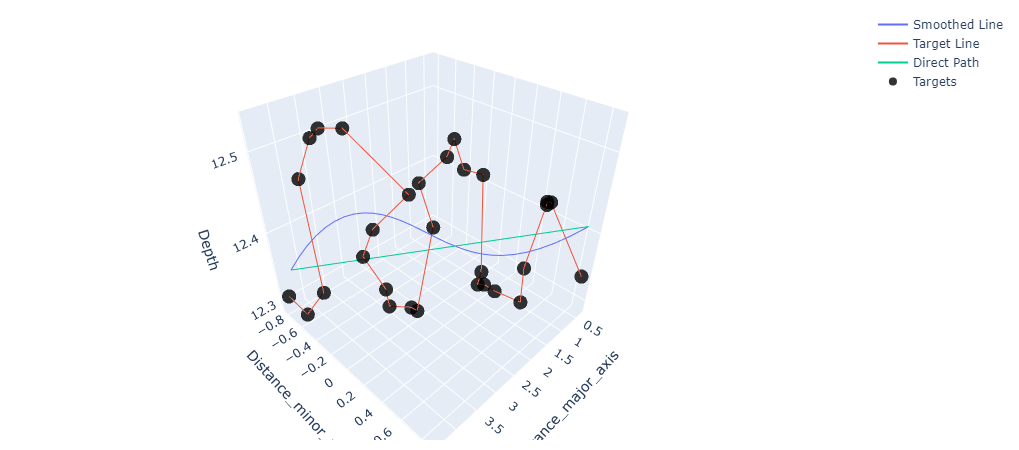

(0.297082492242037, 4.277987888285333, -111.05107839559712)
(0.2948183856802969, 4.245384753796276, -110.77209189124409)


In [7]:
i = 50
trackPlot(dfT,dfR.iloc[i].Process_ID, dfR.iloc[i].Region_ID)
print(regionStats(dfR.iloc[i],dfT,processParams1.wbatParams.mooringNum,path_direct=False))
print(regionStats(dfR.iloc[i],dfT,processParams1.wbatParams.mooringNum,path_direct=True))

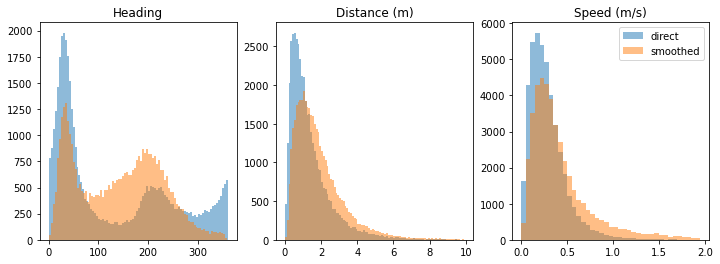

In [17]:
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.hist(dfRSpline.directHead,90,alpha=.5)
plt.hist(dfRSpline.smoothedHead,90,alpha=.5);
plt.title('Heading')
plt.subplot(132)
plt.hist(dfRSpline.directDist,bins=np.arange(0,10,.1),alpha=.5)
plt.hist(dfRSpline.smoothedDist,bins=np.arange(0,10,.1),alpha=.5);
plt.title('Distance (m)')
plt.subplot(133)
plt.hist(dfRSpline.directSpeed,bins=np.arange(0,2,.05),alpha=.5)
plt.hist(dfRSpline.smoothedSpeed,bins=np.arange(0,2,.05),alpha=.5);
plt.title('Speed (m/s)')
plt.legend(['direct','smoothed'])